Code to create and deploy the ml model on the backend.

Format and code taken from: https://www.tensorflow.org/tutorials/structured_data/time_series 

In [1]:
# Install tensorflow to the user system
!pip install tensorflow
!pip install tensorflowjs

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from itertools import product

# Import util functions from util.py
# Lots of the utils are from:
# https://www.tensorflow.org/tutorials/structured_data/time_series
from util import WindowGenerator
from util import split_window
from util import Baseline
from util import make_dataset
from util import compile_and_fit

In [3]:
df = pd.read_csv("eth_price.csv")

df.columns =['EpochDate', 'Price']
df.drop(columns=['EpochDate'], inplace=True)
df.head()

,Price
0,297.9225
1,290.5300
2,292.9725
3,315.8775
4,276.3650


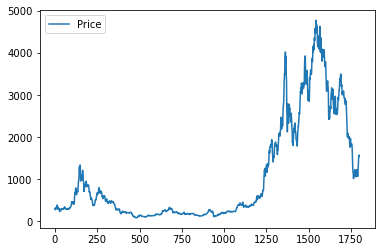

In [4]:
# view ETH price history
# This price history should be over the last 5 ish years
plot_cols = ['Price']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
df.describe().transpose()
column_indices = {name: i for i, name in enumerate(df.columns)}

# train on entire dataframe
# only do this right before deployment
# train_df = df

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [6]:
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_min) / train_max
val_df = (val_df - train_min) / train_max
test_df = (test_df - train_min) / train_max

print(train_min)
print(train_max)

Price    83.5925
dtype: float64
Price    1369.69
dtype: float64


In [7]:
WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.split_window = split_window

In [13]:
baseline = Baseline(label_index=column_indices['Price'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [15]:
wide_window = WindowGenerator(
    input_width=30, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Price'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [17]:
# Here we do a hyperparameter sweep over some parameters to decide what are the best to deploy on our server
results = {}
models = {}

NUM_EPOCHS = 20
hidden_dimensionalities = [8, 16, 32, 64]
learning_rates = [0.1, 0.01, 0.001, 0.001]

for dims, lr in product(hidden_dimensionalities, learning_rates):
    curr_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(dims, return_sequences=True),
      tf.keras.layers.LSTM(dims, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    history = compile_and_fit(curr_model, wide_window, learning_rate=lr)
    
    val_results = curr_model.evaluate(wide_window.val, verbose=0)
    print(val_results)
    results[str(dims) + "_" + str(lr)] = val_results
    models[str(dims) + "_" + str(lr)] = tf.keras.models.clone_model(curr_model)

Epoch 1/20
1230/1230 [==============================] - 12s 8ms/step - loss: 0.0125 - mean_absolute_error: 0.0749 - val_loss: 2.5850 - val_mean_absolute_error: 1.4736
Epoch 2/20
1230/1230 [==============================] - 10s 8ms/step - loss: 0.0100 - mean_absolute_error: 0.0658 - val_loss: 2.4541 - val_mean_absolute_error: 1.4285
Epoch 3/20
1230/1230 [==============================] - 9s 8ms/step - loss: 0.0103 - mean_absolute_error: 0.0667 - val_loss: 2.4115 - val_mean_absolute_error: 1.4134
Epoch 4/20
1230/1230 [==============================] - 10s 8ms/step - loss: 0.0123 - mean_absolute_error: 0.0740 - val_loss: 2.4935 - val_mean_absolute_error: 1.4421
Epoch 5/20
1230/1230 [==============================] - 9s 8ms/step - loss: 0.0096 - mean_absolute_error: 0.0631 - val_loss: 2.4867 - val_mean_absolute_error: 1.4397
[2.486661672592163, 1.439734697341919]
Epoch 1/20
1230/1230 [==============================] - 12s 8ms/step - loss: 0.0214 - mean_absolute_error: 0.1035 - val_loss: 3.

1230/1230 [==============================] - 10s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0471 - val_loss: 2.4092 - val_mean_absolute_error: 1.4058
Epoch 10/20
1230/1230 [==============================] - 10s 8ms/step - loss: 0.0058 - mean_absolute_error: 0.0457 - val_loss: 2.3291 - val_mean_absolute_error: 1.3918
Epoch 11/20
1230/1230 [==============================] - 10s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0451 - val_loss: 2.4703 - val_mean_absolute_error: 1.4469
Epoch 12/20
1230/1230 [==============================] - 10s 8ms/step - loss: 0.0056 - mean_absolute_error: 0.0450 - val_loss: 2.4744 - val_mean_absolute_error: 1.4538
[2.474362373352051, 1.4537816047668457]
Epoch 1/20
1230/1230 [==============================] - 13s 8ms/step - loss: 0.0208 - mean_absolute_error: 0.0955 - val_loss: 2.3608 - val_mean_absolute_error: 1.4020
Epoch 2/20
1230/1230 [==============================] - 10s 8ms/step - loss: 0.0096 - mean_absolute_error: 0.0605 - val_loss: 2.2922 

1230/1230 [==============================] - 11s 9ms/step - loss: 0.0364 - mean_absolute_error: 0.1399 - val_loss: 4.1762 - val_mean_absolute_error: 1.9397
Epoch 6/20
1230/1230 [==============================] - 11s 9ms/step - loss: 0.0383 - mean_absolute_error: 0.1433 - val_loss: 4.2938 - val_mean_absolute_error: 1.9692
Epoch 7/20
1230/1230 [==============================] - 11s 9ms/step - loss: 0.0365 - mean_absolute_error: 0.1392 - val_loss: 4.2009 - val_mean_absolute_error: 1.9463
[4.200883865356445, 1.9462594985961914]
Epoch 1/20
1230/1230 [==============================] - 14s 9ms/step - loss: 0.0194 - mean_absolute_error: 0.0916 - val_loss: 2.8358 - val_mean_absolute_error: 1.5564
Epoch 2/20
1230/1230 [==============================] - 11s 9ms/step - loss: 0.0074 - mean_absolute_error: 0.0542 - val_loss: 2.8608 - val_mean_absolute_error: 1.5645
Epoch 3/20
1230/1230 [==============================] - 11s 9ms/step - loss: 0.0075 - mean_absolute_error: 0.0538 - val_loss: 2.6300 - v

In [21]:
# save the best model to a format that is compatible with tensorflow.js
import tensorflowjs as tfjs

best = 1e9
best_model = ""

for name, value in results.items():
    if value[1] < best:
        best_model = name

print("Best model parameters", best_model)
print("Best model losses", results[best_model])
        
tfjs.converters.save_keras_model(models[best_model], '.')

Best model parameters 64_0.001
Best model losses [2.3603949546813965, 1.3921717405319214]


In [32]:
# View output on a dummy input
# 
a = np.array([
    0.1, 0.2, 0.3, 0.4, 0.5, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.1, 0.2, 0.3,
    0.4, 0.5, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91,])

a = np.expand_dims(a, axis=1)
a = a.reshape(-1, 30, 1)

b = tf.constant(a)
print(b.shape, lstm_model(b))

(1, 30, 1) tf.Tensor(
[[[0.08293108]
  [0.23115587]
  [0.38831043]
  [0.4343667 ]
  [0.5442924 ]
  [0.2427277 ]
  [0.64442   ]
  [0.43104926]
  [0.6461305 ]
  [0.6604145 ]
  [0.7439412 ]
  [0.79530346]
  [0.03090052]
  [0.08831307]
  [0.39816737]
  [0.56551474]
  [0.51097906]
  [0.38713175]
  [0.5474659 ]
  [0.47446454]
  [0.63347876]
  [0.6672974 ]
  [0.742015  ]
  [0.7948834 ]
  [0.25864428]
  [0.74223614]
  [0.6587051 ]
  [0.7507498 ]
  [0.80320585]
  [0.8263015 ]]], shape=(1, 30, 1), dtype=float32)
